# Convolutional Neural Networks

_Life can only be understood backwards; but it must be lived forwards._ - Søren Kierkegaard

**Convolutional Neural Networks (CNNs)** are particularly effective for analyzing structured data like images and sequences. By leveraging convolutional layers, CNNs extract hierarchical patterns from raw inputs for complex tasks such as image classification and time series prediction. We explore the application of **Temporal Convolutional Networks (TCNs)** for capturing dependencies in economic time series. The results from modeling multiple time series data such as CPI components are compared with with classical models like Vector Autoregression (VAR).

In [1]:
# By: Terence Lim, 2020-2025 (terence-lim.github.io)
import numpy as np
import pandas as pd
from pandas import DataFrame, Series
import matplotlib.pyplot as plt
import random
import torch
import torch.nn as nn
import torchinfo
from statsmodels.tsa.api import VAR
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from finds.structured import BusDay
from finds.readers import Alfred
from secret import credentials
# %matplotlib qt
VERBOSE = 0
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# train-test split date
split_date = '2021-12-01'   # training period up to this date

## Convolutions

Convolutional layers are memory-efficient neural network components designed to process spatially structured data, such as images. Unlike fully connected (linear) layers, which require vast numbers of parameters, convolutional layers use localized, shared filters called **kernels** to capture patterns in input data. Mathematically, a convolution operates as follows:

$$
y_{i,j,k} = \sum_{l=1}^{C_1} \sum_{m=0}^{h-1} \sum_{n=0}^{w-1} x_{l, j+m, k+n} \cdot \omega_{i,l,m,n}
$$

Here, $\omega$ is a small kernel (e.g., 3×3) that slides over the image, performing element-wise multiplications and summing the results.




### Image Filters

Convolutions can be interpreted as applying image processing filters, such as:

- Box filter (averaging):
$$
\frac{1}{9}
\begin{bmatrix}
1 & 1 & 1 \\\\
1 & 1 & 1 \\\\
1 & 1 & 1
\end{bmatrix}
$$

- Edge detection filter:
$$
\begin{bmatrix}
-1 & -1 & -1 \\\\
0 & 0 & 0 \\\\
1 & 1 & 1
\end{bmatrix}
$$

Thus, convolutional layers serve as feature extractors, enabling models to detect edges, textures, and patterns crucial for tasks like image classification and segmentation.



### Receptive field and output size

Convolutions operate on local patches of an image, but by stacking multiple layers, they can expand their **receptive field**, allowing the network to capture broader context. Several parameters affect the output size and receptive field:

- Padding: Adds extra pixels around the input to control output size and preserve borders.
- Stride: Controls how far the filter moves across the input, affecting downsampling.
- Dilation: Inserts zeros between kernel elements, expanding the receptive field without increasing parameters.
- Transposed convolution (up-convolution): A learnable upsampling method used to increase output size, often employed in image segmentation models like **U-Net**.


### Computer vision

CNNs process images based on :

- Recurring Patterns: They detect similar structures that appear across different images.
- Multi-Scale Patterns: They recognize features ranging from small edges to large object shapes.
- Local Invariance: They take advantage of the fact that neighboring pixels often have similar values.
- Semantic Grouping: They group together pixels that belong to the same object based on shared patterns.

They excel at computer vision tasks that involve recognizing structured patterns at multiple levels of abstraction. These tasks include:

- **Image Classification**: CNNs are highly effective at identifying what object is present in an image by detecting low-level patterns (like edges and textures) and gradually building up to high-level semantic features (like object categories).

- **Object Detection**: By capturing patterns at various scales and identifying object parts, CNNs can localize and label multiple objects within an image, even if they vary in size or position.

- **Semantic Segmentation**: CNNs perform well at assigning a class label to each pixel in an image by grouping together pixels that form the same object or region.

AlexNet (2012) was the first deep network to outperform non-deep vision systems, winning the ImageNet challenge competition and kicking off the Deep Learning revolution. Winning the 2015 competition, ResNet introduced shortcut "residual connections" for gradients in convolutional architectures.  The U-Net (2016) model designed a symmetric hourglass-shaped architecture dsemantic segmentation, combining down-sampling to capture context with up-sampling to produce higher output resolution. More recently, Vision Transformer (ViT) models have incorporated transformer encoders by dividing images into patches, treating each patch as a token.

## Temporal convolutional networks (TCN)

**Temporal Convolutional Networks (TCNs)** are deep convolutional architectures designed for sequence data. They utilize causal and dilated convolutions along with residual connections to model long-range dependencies efficiently. Unlike CNNs for images, TCNs handle sequential data such as time series, text, and audio.

- Causal Convolutions: Ensure that each output at time $t$ only depends on current and past inputs — preserving the temporal order:

$$
y_t = \sum_{i=0}^{k-1} w_i x_{t-i}
$$

- Dilated Convolutions: Introduce gaps between filter (kernel) elements to capture long-range dependencies without expanding filter size:

$$
y_t = \sum_{i=0}^{k-1} w_i x_{t - d \cdot i}
$$

- Residual Connections: Allow gradients to flow efficiently through deep networks, mitigating vanishing gradient issues:

$$
\text{Output} = x + F(x)
$$

Key hyperparameters of TCNs include:
- `kernel_size`: Size of convolutional filter.
- `dropout`: Regularization to prevent overfitting.
- `blocks`: Number of stacked convolutional layers.
- `dilation`: Grows exponentially (e.g., 1, 2, 4, ...).
- `activation`: Non-linear activation, typically ReLU.


In [2]:
class TCN(torch.nn.Module):
    class CausalConv1dBlock(torch.nn.Module):
        """Conv1d block with ReLU, skip, dropout, dilation and padding"""
        
        def __init__(self, in_channels, out_channels, kernel_size, dilation,
                     dropout):
            super().__init__()

            # print('kernel', kernel_size, 'dilation', dilation)
            self.network = torch.nn.Sequential(
                torch.nn.ConstantPad1d(((kernel_size-1)*dilation, 0), 0),
                torch.nn.Conv1d(in_channels, out_channels, kernel_size,
                                dilation=dilation),
                torch.nn.ReLU(),
                torch.nn.ConstantPad1d(((kernel_size-1)*dilation, 0), 0),
                torch.nn.Conv1d(out_channels, out_channels, kernel_size,
                                dilation=dilation),
                torch.nn.ReLU(),
                torch.nn.Dropout(dropout))
            self.skip = lambda x: x
            if in_channels != out_channels:   # downsample for skip if necessary
                self.skip = torch.nn.Conv1d(in_channels, out_channels, 1)

        def forward(self, x):
            return self.network(x) + self.skip(x)  # with skip connection


    def __init__(self, n_features, blocks, kernel_size, dropout):
        """TCN model by connecting multiple convolution layers"""
        super().__init__()
        in_channels = n_features
        L = []
        for dilation, hidden in enumerate(blocks):
            L.append(self.CausalConv1dBlock(in_channels=in_channels,
                                            out_channels=hidden,
                                            kernel_size=kernel_size,
                                            dilation=2**dilation,
                                            dropout=dropout))
            in_channels = hidden
        self.network = torch.nn.Sequential(*L) if L else lambda x: x
        if L:
            self.classifier = torch.nn.Conv1d(in_channels, n_features, 1)
        else:
            self.classifier = torch.nn.Sequential(
                torch.nn.ConstantPad1d((kernel_size-1, 0), 0),                
                torch.nn.Conv1d(in_channels, n_features, kernel_size))

    def forward(self, x):
        """input is (B, n_features, L)), linear expects (B, * n_features)"""
        return self.classifier(self.network(x))

    def save(self, filename):
        """save model state to filename"""
        return torch.save(self.state_dict(), filename)

    def load(self, filename):
        """load model name from filename"""
        self.load_state_dict(torch.load(filename, map_location='cpu'))
        return self

### Data preparation

The dataset comprises economic time series of CPI components obtained from FRED (Federal Reserve Economic Data). The data, covering various CPI categories (e.g., food, housing, transportation), is log-transformed and differenced for stationarity and standardized using `StandardScaler` to mean 0 and variance 1.

In [3]:
alf = Alfred(api_key=credentials['fred']['api_key'], verbose=-1)
vspans = alf.date_spans('USREC')    # recession periods for plots

In [4]:
# CPI for U.S. City Average: Monthly, Seasonally Adjusted
# https://fred.stlouisfed.org/release/tables?rid=10&eid=34483
# 'CUSR0000SEEA'
series_ids = ['CPIFABSL', 'CPIHOSSL', 'CPIAPPSL', 'CPITRNSL', 'CPIMEDSL', 'CPIOGSSL']
df = pd.concat([alf(s, log=1, diff=1) for s in series_ids], axis=1)\
       .dropna()\
       .sort_index()
df.index = BusDay.to_datetime(df.index)
df.index.freq = 'M'     # set index to datetime type and freq = 'M'

/tmp/ipykernel_1025513/4272565358.py:9: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df.index.freq = 'M'     # set index to datetime type and freq = 'M'


In [5]:
names = [s[s.find(':')+2:s.find(' in ')] for s in alf.header(series_ids)]
names

['Food and Beverages',
 'Housing',
 'Apparel',
 'Transportation',
 'Medical Care',
 'Other Goods and Services']

In [6]:
# Standardize the data data
scaler = StandardScaler().fit(df)
scaled_data = DataFrame(scaler.transform(df), columns=names, index=df.index)
scaled_data

,Food and Beverages,Housing,Apparel,Transportation,Medical Care,Other Goods and Services
date,,,,,,
1967-02-28,-1.520716,-1.129800,0.533990,0.266586,-0.248585,-1.017195
1967-03-31,-0.805655,-1.129800,0.124553,-0.267488,-0.253160,-0.284868
1967-04-30,-1.522780,-0.063784,0.529140,0.263339,0.988995,-1.017195
1967-05-31,-0.805655,-0.067262,0.122142,-0.003280,-0.266687,-0.286982
1967-06-30,1.339539,-1.129800,0.524347,-0.267488,0.962232,-0.289083
...,...,...,...,...,...,...
2024-10-31,-0.252031,0.063171,-2.110286,-0.203592,-0.692758,-0.172972
2024-11-30,-0.053379,-0.037266,-0.114479,0.027062,-0.702581,0.085335
2024-12-31,-0.180743,-0.209529,-0.015224,0.767819,-1.058184,-1.113129


In [7]:
ntrain = sum(scaled_data.index < split_date)
M = scaled_data.shape[1]      # M is number of time series

### Training

The TCN is trained to predict the next time step of the CPI components using past observations. Training involves splitting data into train and test sets, and using the Adam optimizer to minimize mean squared error (MSE) between predictions and actual values.



In [8]:
# Model training parameters
seq_len = 8         # length of each input sequence for TCN
batch_size = 16
step_size = 30      # learning rate scheduler step size
lr = 0.01           # initial learning rate
num_lr = 3
num_epochs = step_size * num_lr
results = {}        # to collect evaluate results
train_loss = {}
test_loss = {}

In [9]:
# Form input data from training set
n_features = scaled_data.shape[1]    # number of input planes
train_exs = [scaled_data.iloc[(i - seq_len):(i + 1)].values
             for i in range(seq_len, ntrain)]

In [10]:
# train_ex should have dimension (batch size, channels, sequence length+1)
train_ex = torch.tensor(scaled_data.values[:ntrain].T)[None,:,:].float().to(device)


First, a baseline model comprising just a single **1D Conv layer** is trained to predict next time step



In [11]:
model = torch.nn.Conv1d(n_features, n_features, kernel_size=1).to(device)
print(model)
print(torchinfo.summary(model))
modelname = "1D-Convolution"
train_loss[modelname] = []
test_loss[modelname] = []
optimizer = torch.optim.Adam(model.parameters())
loss_function = nn.MSELoss()

Conv1d(6, 6, kernel_size=(1,), stride=(1,))
Layer (type:depth-idx)                   Param #
Conv1d                                   42
Total params: 42
Trainable params: 42
Non-trainable params: 0


In [12]:
for epoch in range(num_epochs):
    for _ in range(batch_size):
        total_loss = 0.0
        model.train()
        model.zero_grad()
        X = train_ex[:,:,:-1]
        Y = train_ex[:,:,1:]
        output = model(X)
        loss = loss_function(output, Y)  # calculated over all outputs
        total_loss += float(loss)
        loss.backward()
        optimizer.step()

    model.eval()
    train_loss[modelname].append(total_loss)
    
    X = torch.tensor(scaled_data.values.T)[None,:,:].float().to(device)
    pred = model(X).cpu().detach().numpy()[0,:,:].T
    test_loss[modelname] = mean_squared_error(scaled_data.values[ntrain:],
                                              pred[ntrain-1:-1])
results[modelname] = {
    'Train Error': mean_squared_error(scaled_data.values[1:ntrain],
                                        pred[:ntrain-1]),
    'Test Error': mean_squared_error(scaled_data.values[ntrain:],
                                        pred[ntrain-1:-1])
}

Save the fitted weights to compare with classical Vector Autoregression (VAR) models.

In [13]:
conv1d_weights = np.vstack([model.bias.cpu().detach().numpy(),
                            model.weight.cpu().detach().numpy()[:,:,0].T])

Next, we train various TCN configurations, utilizing StepLR learning rate scheduler and shuffled batches, while varying:

- number of layers (blocks): 1, 2
- different kernel sizes: 1, 2
- dropout rates: 0, 0.5.



In [14]:
# [1,1,0], [1,2,0], [2,1,0], [2,2,0], [1,1,0.5], [1,2,0.5], [2,1,0.5], [2,2,0.5]
for block, kernel_size, dropout in [[1,1,0], [1,2,0], [2,1,0], [2,2,0],  [2,2,0.3]]:
    modelname = f"TCN(b={block},k={kernel_size},d={dropout:.1f})"
    train_loss[modelname] = []
    test_loss[modelname] = []

    # Set model, optimizer, loss function and learning rate scheduler
    model = TCN(n_features=n_features, 
                blocks=[n_features]*block,
                kernel_size=kernel_size,
                dropout=dropout).to(device)
    print()
    print('******', modelname, '******')
    print(model)
    print(torchinfo.summary(model))

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.StepLR(
        optimizer, gamma=0.1, step_size=step_size
    )
    loss_function = nn.MSELoss()

    # Run training loop over num_epochs with batch_size
    num_epochs = step_size * num_lr
    for epoch in range(num_epochs):

        # shuffle indxs into batches
        idxs = np.arange(len(train_exs))
        random.shuffle(idxs)
        batches = [idxs[i:min(len(idxs), i + batch_size)]
                   for i in range(0, len(idxs), batch_size)]

        # train by batch
        total_loss = 0.0
        model.train()
        for batch in batches:
            # input has shape (batch_size, n_features, seq_len)
            # Creating a tensor from a list of numpy.ndarrays is extremely slow.
            nparray = np.array([[train_exs[idx][seq] for idx in batch]
                                for seq in range(seq_len+1)])
            train_ex = torch.tensor(nparray).permute(1, 2, 0).float().to(device)
            model.zero_grad()
            X = train_ex[:,:,:-1]
            Y = train_ex[:,:,1:]
            output = model(X)
            loss = loss_function(output, Y)  # calculated over all outputs
            total_loss += float(loss) / len(batches)
            loss.backward()
            optimizer.step()
            scheduler.step()

        model.eval()
        train_loss[modelname].append(total_loss)
        if VERBOSE and (epoch % (step_size//2)) == 0:
            print(epoch, num_epochs, optimizer.param_groups[0]['lr'], total_loss)

        # Compute MSE of one-period ahead forecast error in train and test sets
        X = torch.tensor(scaled_data.values.T)[None,:,:].float().to(device)
        pred = model(X).cpu().detach().numpy()[0,:,:].T
        test_loss[modelname].append(mean_squared_error(scaled_data.values[ntrain:],
                                                       pred[ntrain-1:-1]))

    results[modelname] = {
        'Train Error': mean_squared_error(scaled_data.values[1:ntrain],
                                            pred[:ntrain-1]),
        'Test Error': mean_squared_error(scaled_data.values[ntrain:],
                                            pred[ntrain-1:-1])
    }
    #print('Blocks:', block, 'Kernel size:', kernel_size, results[modelname])
    #print(pd.concat(res, axis=1).T)


****** TCN(b=1,k=1,d=0.0) ******
TCN(
  (network): Sequential(
    (0): CausalConv1dBlock(
      (network): Sequential(
        (0): ConstantPad1d(padding=(0, 0), value=0)
        (1): Conv1d(6, 6, kernel_size=(1,), stride=(1,))
        (2): ReLU()
        (3): ConstantPad1d(padding=(0, 0), value=0)
        (4): Conv1d(6, 6, kernel_size=(1,), stride=(1,))
        (5): ReLU()
        (6): Dropout(p=0, inplace=False)
      )
    )
  )
  (classifier): Conv1d(6, 6, kernel_size=(1,), stride=(1,))
)
Layer (type:depth-idx)                   Param #
TCN                                      --
├─Sequential: 1-1                        --
│    └─CausalConv1dBlock: 2-1            --
│    │    └─Sequential: 3-1              84
├─Conv1d: 1-2                            42
Total params: 126
Trainable params: 126
Non-trainable params: 0

****** TCN(b=1,k=2,d=0.0) ******
TCN(
  (network): Sequential(
    (0): CausalConv1dBlock(
      (network): Sequential(
        (0): ConstantPad1d(padding=(1, 0), val

### Evaluation

Training and test errors (MSE) from one-step-ahead forecasting are collected across models. Additionally, training and testing loss curves are plotted to analyze convergence and overfitting tendencies of different configurations.



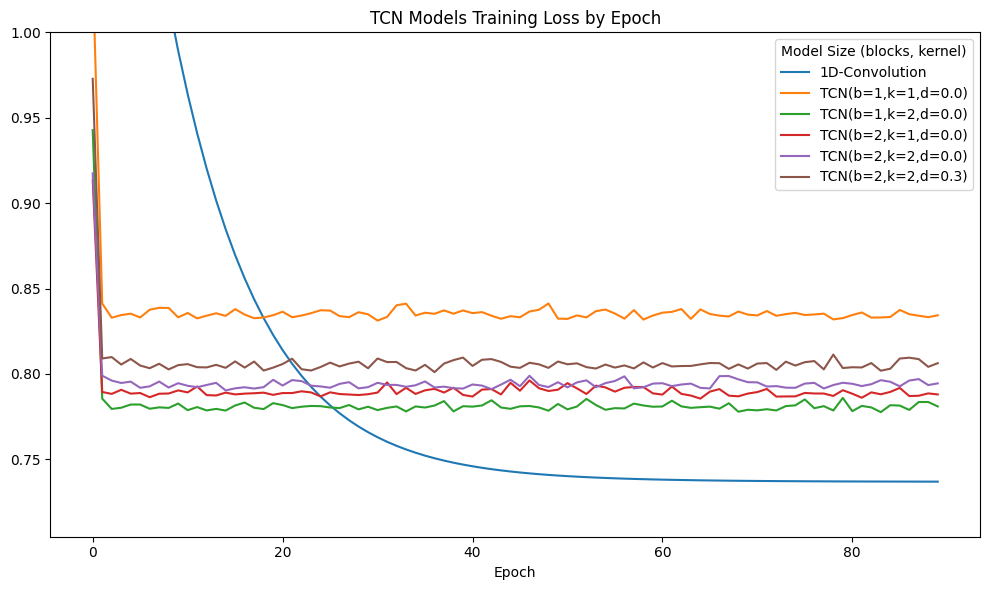

In [15]:
fig, ax = plt.subplots(figsize=(10, 6))
DataFrame(train_loss).plot(ax=ax)
ax.set_ylim(top=1.0)
ax.set_title(f"TCN Models Training Loss by Epoch")
ax.set_xlabel('Epoch')
ax.legend(title='Model Size (blocks, kernel)')
plt.tight_layout()

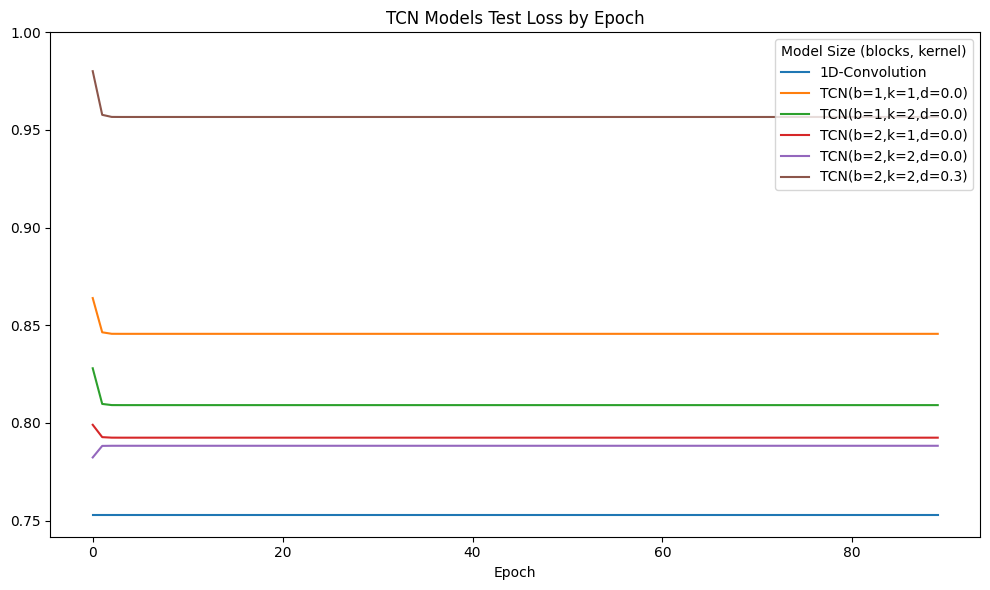

In [16]:
fig, ax = plt.subplots(figsize=(10, 6))
DataFrame(test_loss).plot(ax=ax)
ax.set_ylim(top=1.0)
ax.set_title(f"TCN Models Test Loss by Epoch")
ax.set_xlabel('Epoch')
ax.legend(title='Model Size (blocks, kernel)')
plt.tight_layout()

In [17]:
print('Sorted by Test Error')
DataFrame(results).T.sort_values('Test Error')

Sorted by Test Error


,Train Error,Test Error
1D-Convolution,0.736907,0.753075
"TCN(b=2,k=2,d=0.0)",0.786185,0.788295
"TCN(b=2,k=1,d=0.0)",0.788457,0.792443
"TCN(b=1,k=2,d=0.0)",0.775419,0.809113
"TCN(b=1,k=1,d=0.0)",0.832984,0.845615
"TCN(b=2,k=2,d=0.3)",0.790285,0.956657


## Vector Autoregression

**Vector Autoregression (VAR)** is a statistical time series model that captures linear interdependencies across multiple time series.

In [18]:
var_model = VAR(scaled_data.iloc[:ntrain], freq='ME')

### Lag order

The lagged coefficients estimated from the Vector Autoregression help predict multi-step future outcomes. The optimal lag order (p) can be selected using infomation criteria such as AIC, BIC, HQIC, or FPE.


In [19]:
# up to max number p of VAR(p) lags
maxlags = 6

print("Optimal number of VAR(p) lags selected by various IC")
DataFrame({ic: var_model.fit(maxlags=maxlags, ic=ic).k_ar
           for ic in ['aic', 'fpe', 'hqic', 'bic']},
          index=['optimal p:'])\
          .rename_axis(columns='IC:')

Optimal number of VAR(p) lags selected by various IC


IC:,aic,fpe,hqic,bic
optimal p:,3,3,2,2


In [20]:
# Fit VAR(p) models
var_models = {p: var_model.fit(p) for p in range(1, maxlags+1)} # fit models

In [21]:
# Show model summary for VAR(1)
print(var_models[1].summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sat, 15, Mar, 2025
Time:                     04:58:13
--------------------------------------------------------------------
No. of Equations:         6.00000    BIC:                   -1.67401
Nobs:                     657.000    HQIC:                  -1.84967
Log likelihood:          -4907.30    FPE:                   0.140733
AIC:                     -1.96089    Det(Omega_mle):        0.132063
--------------------------------------------------------------------
Results for equation Food and Beverages
                                 coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------------------------
const                              -0.000685         0.035822           -0.019           0.985
L1.Food and Beverages               0.309512         0.037889            8.169        

### Var(1) and Conv1d

The coefficients learned by VAR(1) models are compared to the learned weights of Conv1D layers, illustrating how classical linear models relate to convolution-based neural approaches in time series forecasting.

In [22]:
print('Coefficients of VAR(1) model')
DataFrame(np.vstack([var_models[1].intercept, var_models[1].coefs[0].T]),
          columns=var_models[1].names, index=var_models[1].exog_names).round(4)

Coefficients of VAR(1) model


,Food and Beverages,Housing,Apparel,Transportation,Medical Care,Other Goods and Services
const,-0.0007,-0.0161,-0.0041,0.0013,0.0331,-0.0095
L1.Food and Beverages,0.3095,0.1634,0.0322,0.0211,0.0246,0.0263
L1.Housing,0.2128,0.4944,0.1080,0.0710,0.2329,0.0767
L1.Apparel,-0.0030,0.0386,0.1370,0.0325,0.0444,0.0948
L1.Transportation,-0.0061,0.0746,0.1877,0.4257,0.0058,0.0181
L1.Medical Care,-0.0072,0.2118,0.1161,0.0501,0.4310,0.2606
L1.Other Goods and Services,0.0100,-0.0226,0.0071,-0.0352,0.1145,0.0097


In [23]:
print('Tensor weights of Conv1D')
DataFrame(conv1d_weights, columns=names, index=['bias'] + names).round(4)

Tensor weights of Conv1D


,Food and Beverages,Housing,Apparel,Transportation,Medical Care,Other Goods and Services
bias,-0.0011,-0.0167,-0.0041,0.0014,0.0330,-0.0086
Food and Beverages,0.3154,0.1677,0.0322,0.0210,0.0253,0.0233
Housing,0.1997,0.4808,0.1080,0.0713,0.2302,0.0861
Apparel,-0.0014,0.0396,0.1370,0.0326,0.0447,0.0936
Transportation,-0.0037,0.0773,0.1877,0.4256,0.0063,0.0166
Medical Care,-0.0018,0.2197,0.1160,0.0493,0.4323,0.2514
Other Goods and Services,0.0105,-0.0227,0.0072,-0.0349,0.1146,0.0115


### Evaluation

The forecasting accuracy of VAR models, measured by train and test MSE, is compared across different lag orders.

In [24]:

# Calculate forecast errors for each observation and model
test_errors = {p: list() for p in range(maxlags+1)}
train_errors = {p: list() for p in range(maxlags+1)}

In [25]:
for i in range(maxlags, len(scaled_data)-1):
    data = scaled_data.iloc[i].values

    # test or train sample
    var_errors = train_errors if i < ntrain else test_errors
    
    # error of unconditional mean forecast
    var_errors[0].append(mean_squared_error(data, scaled_data.iloc[:ntrain].mean()))

    # accumulate to error of VAR(p) model forecasts
    for p in range(1, maxlags+1):
        pred = var_models[p].forecast(scaled_data.iloc[:i].values, 1)
        var_errors[p].append(mean_squared_error(data.reshape(1, -1), pred))

In [26]:
# Collect mean test and train set errors of all VAR(p) models
print('VAR models train and test set errors')
out = DataFrame({'Train Error': {f"VAR({p})" : np.mean(errors)
                                 for p, errors in train_errors.items()},
                 'Test Error':  {f"VAR({p})" : np.mean(errors)
                                 for p, errors in test_errors.items()}})
out

VAR models train and test set errors


,Train Error,Test Error
VAR(0),1.009966,0.936672
VAR(1),0.739496,0.757588
VAR(2),0.696483,0.754189
VAR(3),0.680224,0.739767
VAR(4),0.671862,0.750212
VAR(5),0.657304,0.739927
VAR(6),0.647010,0.744329


 Error plots are generated to determine the optimal lag order for best predictive performance.

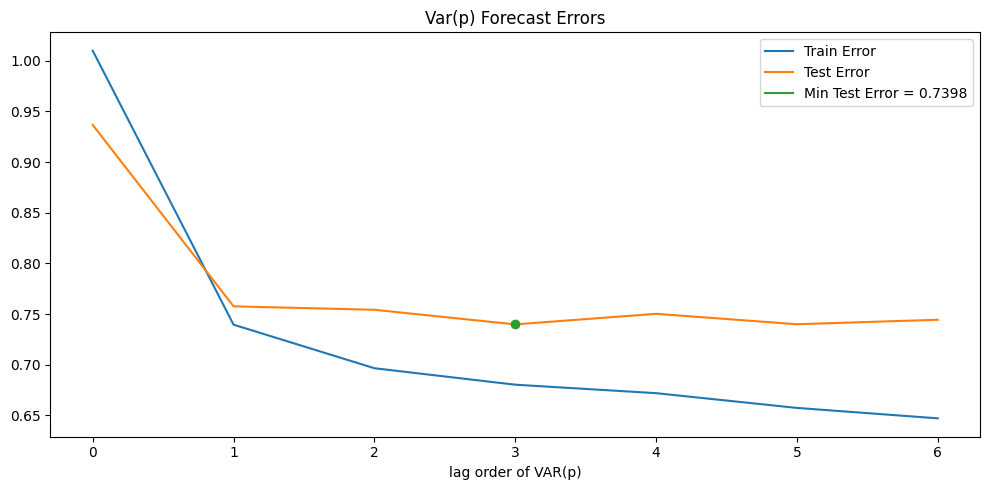

In [27]:
# Plot Errors
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(np.arange(len(out)), out['Train Error'], color="C0")
ax.plot(np.arange(len(out)), out['Test Error'], color="C1")
ax.plot([], [], color="C2")   # dummy for legend labels
argmin = out['Test Error'].argmin()
ax.plot(argmin, out.iloc[argmin]['Test Error'], 'o', color="C2")
ax.set_title(f'Var(p) Forecast Errors')
ax.set_xlabel('lag order of VAR(p)')
ax.legend(['Train Error', 'Test Error',
           f'Min Test Error = {out.iloc[argmin]["Test Error"]:.4f}'],
          loc='upper right')
plt.tight_layout()

**References:**

Philipp Krähenbühl, 2020-2024, "AI394T Deep Learning course materials", retrieved from
https://www.philkr.net/dl_class/material and https://ut.philkr.net/deeplearning/

Philipp Krähenbühl, 2025, "AI395T Advances in Deep Learning course materials", retrieved from https://ut.philkr.net/advances_in_deeplearning/